In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# @title
# Auxiliar function
def display_as_table(df, title, shape=(10,5)):
  # Create a figure and axes
  fig, ax = plt.subplots(figsize=shape, facecolor="#00000000")

  ax.axis('off')
  ax.axis('tight')

  table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

  table.auto_set_font_size(False)
  table.set_fontsize(10)

  for col_idx, col_name in enumerate(df.columns):
      if col_name == "top":
          for row_idx in range(len(df) + 1):
              cell_idx = (row_idx, col_idx)
              if cell_idx in table._cells:
                  table._cells[cell_idx].set_width(0.4)

  fig.suptitle(title)
  fig.tight_layout()

  plt.show()

# EDA Annotations Procesado
Después de aplicado lo siguiente en Annotations original:

\* Referirse a `src/preprocessing/annotation_processor.py`
1. Re-proporcionar distribución de clases:

  1.1 Extraer todos los casos positivos (para anomalías de calcificaciones y masas).

  1.2 Extraer una muestra aleatoria del número exacto de casos negativos necesario para obtener una proporción de 85/15 de casos positivos (paso 1.1) a casos negativos.

  1.3 Fijar casos positivos como clase "0" y negativos como clase "1", indicado en la columna `finding_categories`.

4. Aplicar un split de 70/15/15 para entrenamiento, validación y pruebas, respectivamente, indicado en la columna `split`.

5. Corregir las cajas delimitadoras de anomalía acotando `xmin`y `xmax`entre 0 y `width`, y `ymin`y `ymax`entre 0 y `height`, de modo que se eliminen las coordenadas inválidas.

6. Reescalar las cajas delimitadoras a las dimensiones objetivo (640, 640).

7. Traducir las cajas delimitadoras a formato YOLO `bx` (x central), `by` (y central), `bw` (ancho) y `bh` (alto). Estas se encuentran en columnas con sus respectivos nombres.

In [3]:
df = pd.read_csv('annotations_processed.csv')
display(df.head())

print("Data Shape:", df.shape)

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,xmin,ymin,xmax,ymax,split,bx,by,bh,bw,directory_path
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,640,640,BI-RADS 4,DENSITY C,0,...,538.317690,315.022629,567.538281,337.055145,train,0.863950,0.509436,0.034426,0.045657,output/images/48575a27b7c992427041a82fa750d3fa...
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,640,640,BI-RADS 4,DENSITY C,0,...,545.526842,225.693687,571.840011,246.329058,train,0.872943,0.368768,0.032243,0.041114,output/images/48575a27b7c992427041a82fa750d3fa...
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,640,640,BI-RADS 3,DENSITY C,0,...,32.662629,395.099044,100.476569,437.224808,val,0.104015,0.650253,0.065822,0.105959,output/images/5683854eafabc34f6d854000d2ac6c2d...
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,640,640,BI-RADS 3,DENSITY C,0,...,32.662629,372.060497,95.514516,412.212372,val,0.100138,0.612713,0.062737,0.098206,output/images/5683854eafabc34f6d854000d2ac6c2d...
4,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,f581ef53bb7e61f4575db33eceac8ff8,L,CC,640,640,BI-RADS 4,DENSITY C,0,...,134.599777,254.273557,185.682743,315.582940,train,0.250221,0.445200,0.095796,0.079817,output/images/7c51789da6c462e55bcb95c2a7d437ee...


Data Shape: (1975, 21)


## Descripción de columnas

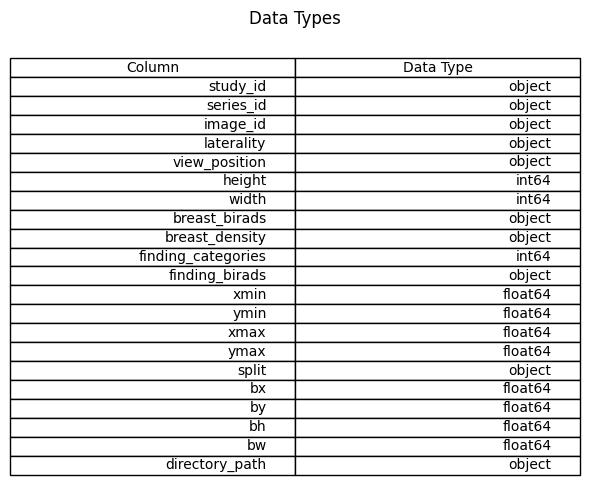

In [4]:
display_as_table(pd.DataFrame
                 .from_dict(df.dtypes.to_dict(), orient='index', columns=['Data Type'])
                 .reset_index().rename(columns={'index': 'Column'}),
                 "Data Types",
                 shape=(6, 5))

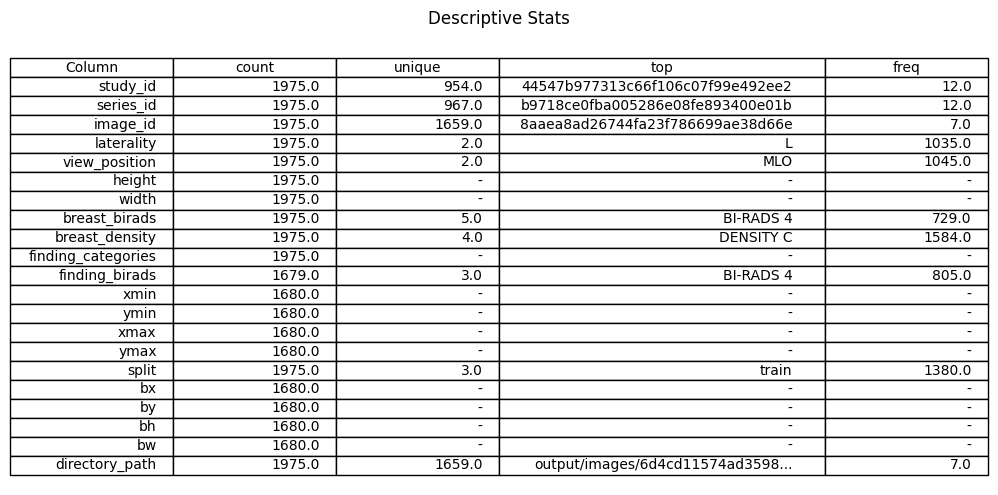

In [5]:
df_desc = (df.describe(include='all').T.reset_index()
          .rename(columns={'index': 'Column'})
          [["Column", "count", "unique", "top", "freq"]])
df_desc.at[df_desc.shape[0]-1,'top'] = df_desc.iloc[-1]['top'][:30] + '...'
df_desc = df_desc.infer_objects(copy=False).fillna('-')
display_as_table(df_desc, "Descriptive Stats")

## Datos faltantes

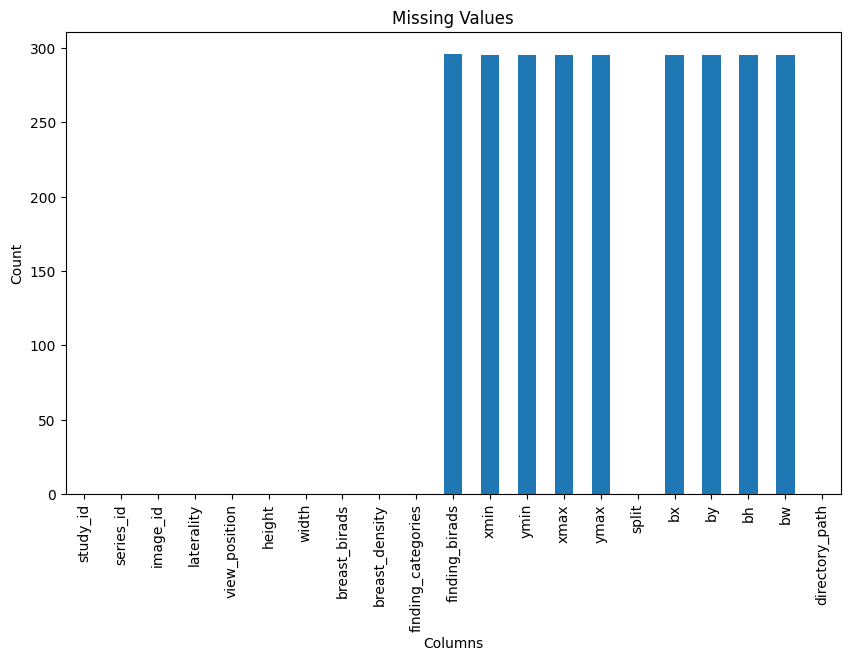

In [6]:
plt.figure(figsize=(10, 6), facecolor="#00000000")
df.isnull().sum().plot(kind='bar')
plt.title('Missing Values')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

## Variables Categóricas

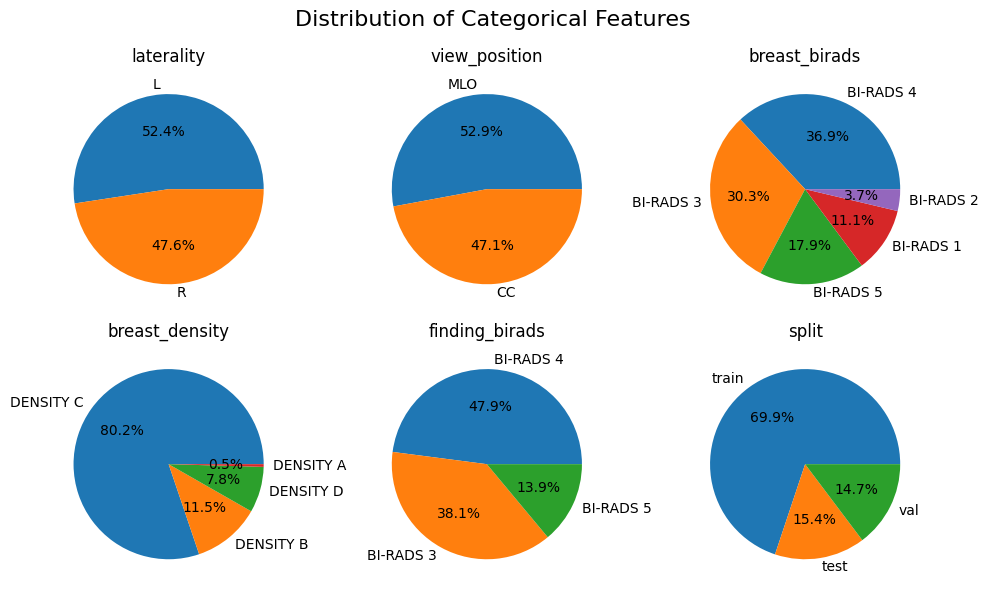

In [7]:
# Unique Values for categorical features
categorical_cols = ['laterality', 'view_position', 'breast_birads', 'breast_density', 'finding_birads', 'split']

fig, axes = plt.subplots(2, 3, figsize=(10, 6), facecolor="#00000000")
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Distribution of Categorical Features', fontsize=16)
plt.tight_layout()
plt.show()

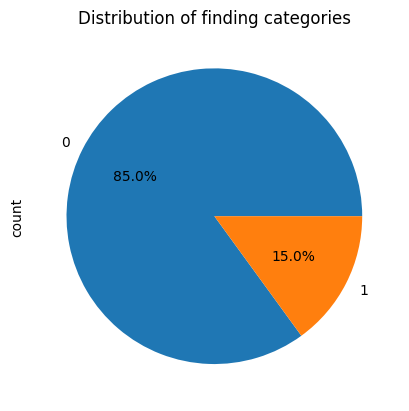

In [16]:
df['finding_categories'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Distribution of finding categories')
plt.show()

## Variables Numéricas

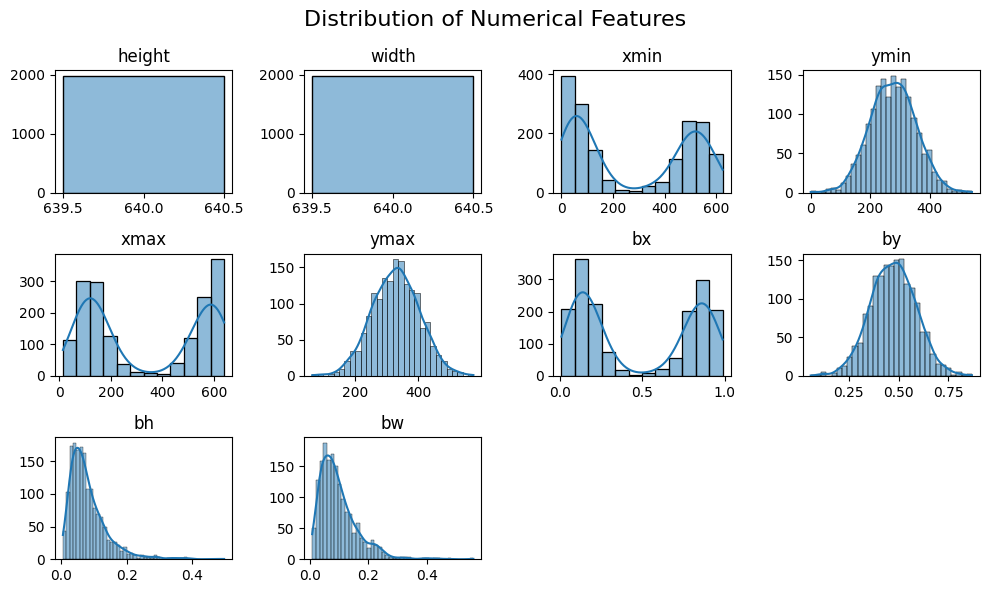

In [8]:
numerical_features = ['height', 'width', 'xmin', 'ymin', 'xmax', 'ymax', 'bx', 'by', 'bh', 'bw']

# histograms
plt.figure(figsize=(10, 6), facecolor="#00000000")
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

- Alto y ancho de todos los datos es 640, de acuerdo a la transformación aplicada sobre las anotaciones.
- `xmin` tiene dos picos, entre 0-100 y alrededor de 500. `xmax` presenta una distribución similar, excepto que cada pico se encuentra ligeramente más a la derecha que los de `xmin`. Esto va acorde a la descripción de cada coordenada, puesto que marcan el inicio y final de las caja delimitadoras. Además, corresponde con el comportamiento de `bx`. También puede indicar una tendencia de las anomalías a ubicarse horizontalmente en la periferia de las mamografías, en lugar de centrales.
- `ymin` y `ymax` presentan distribuciones aparentemente simétricas, ambas centradas en un punto entre 250-350, aunque ligeramente mayor para `ymax`. Esto corresponde con el comportamiento de `by`, y parece indicar de que la altura de las cajas delimitadoras, así como su ubicación vertical, presenta poca variación.
- La distribución de `bh` y `bw` va acorde con las conclusiones anteriores, dando indicativo de que las anomalías presentan poca variación en tamaño.

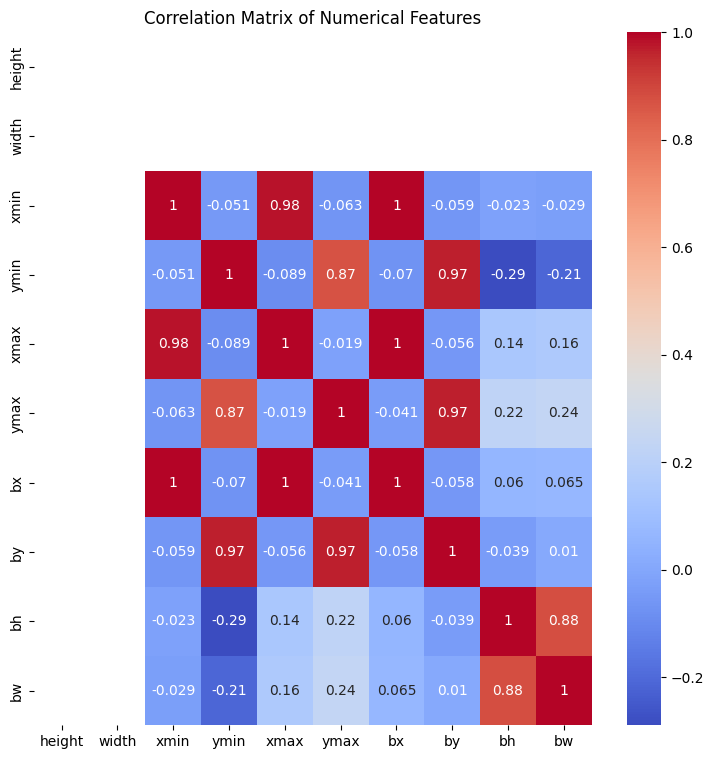

In [9]:
# correlation matrix heatmap (for all numerical features)
plt.figure(figsize=(9, 9), facecolor="#00000000")
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

No existe correlación significativa entre variables que ya no estén de por sí relacionadas conceptualmente. Las correlaciones fuertes que pueden verse (`xmin`, `xmax`, `bx`; `ymin`, `ymax`, `bh`), se deben a que los conceptos que representan están relacionados entre sí.

## Relaciones entre Variables


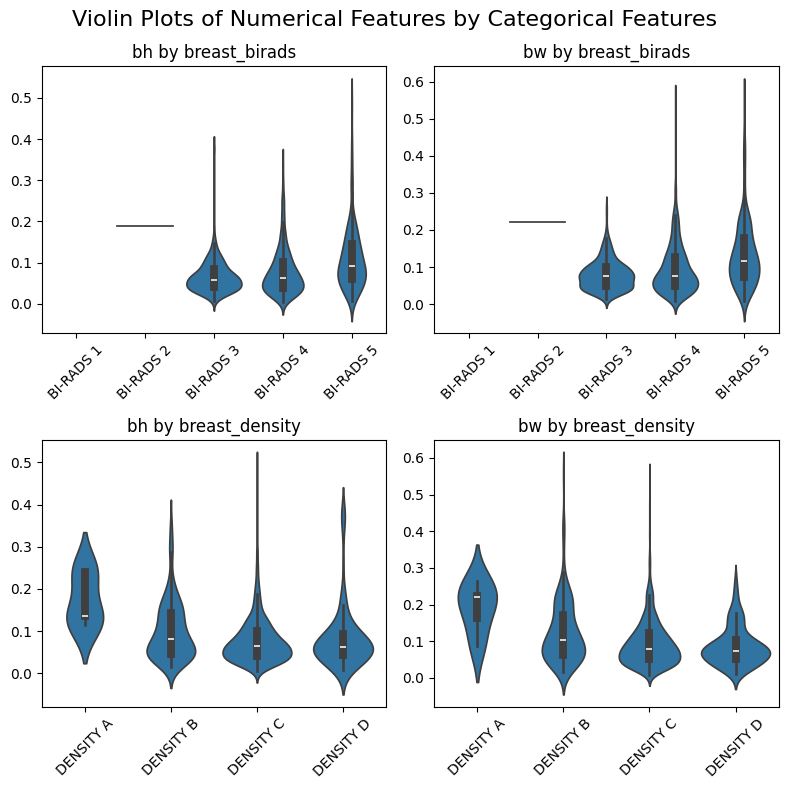

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), facecolor="#00000000")
axes = axes.flatten()
categorical_cols = ['breast_birads', 'breast_density']
i = 0
for cat_col in categorical_cols:
    for num_col in ['bh', 'bw']:
        sorted_categories = sorted(df[cat_col].dropna().unique())
        sns.violinplot(x=cat_col, y=num_col, data=df, order=sorted_categories, ax=axes[i])
        axes[i].set_title(f'{num_col} by {cat_col}')
        axes[i].tick_params(axis='x', labelrotation=45)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        i += 1

fig.suptitle('Violin Plots of Numerical Features by Categorical Features', fontsize=16)
fig.tight_layout()
plt.show()

- Puede notarse que entre mayor sea `breast_birads`, la distribución de `bh` y la de `bw` empiezan a verse más achatadas y se extienden hacia valores mayores. Esto puede ser un ligero indicativo de que hay mayor riesgo de cáncer asociado a anomalías de mayor tamaño.
- Existe una ligera tendencia que entre mayor sea la densidad, tanto la distribución de `bh` como `bw` empiezan a concentrarse más alrededor de medidas más pequeñas, hasta asentarse cada una en un punto mínimo. Esto puede dar indicio de que las anomalías suelen tener menor tamaño en mamas de mayor densidad, dificultando así su diagnóstico.

## Correlación con tipo de caso (`finding_categories`)

In [11]:
df_encoded = df.drop(columns=["study_id", "series_id", "image_id", "directory_path", "height", "width", "split"])
label_encoder = LabelEncoder()

# Encode categorical features
categorical_cols = ['laterality', 'view_position', 'breast_birads', 'finding_birads', 'breast_density']
for col in categorical_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

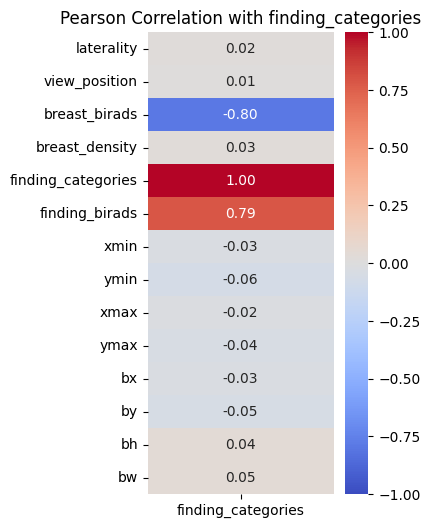

In [12]:
# Calculate Pearson correlation
plt.figure(figsize=(3, 6), facecolor="#00000000")
sns.heatmap(df_encoded.corr()[['finding_categories']], annot=True,
            cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Pearson Correlation with finding_categories')
plt.show()

- No existe correlación significativa entre el diagnóstivo del caso y gran parte de características de las anomalías detectadas.
- La excepción a esto son `breast_birads` y `finding_birads`, pero estas mismas variables también hacen parte del diagnóstico, indicando la gravedad del mismo, por lo que no puede decirse que alguna de las características en la tabla facilite el diagnóstico como tal.